In [1]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import steamspypi
import steamreviews


load_dotenv()
API_KEY = os.getenv("API_KEY")


# Collect the 100 most popular games on steam

In [2]:
data_request = {"request": "top100owned"}
data = steamspypi.download(data_request)
df = pd.DataFrame(data.values())
df = df[['name', 'appid']]
display(df.head())


,name,appid
0,Dota 2,570
1,Counter-Strike: Global Offensive,730
2,PUBG: BATTLEGROUNDS,578080
3,New World,1063730
4,Palworld,1623730


In [3]:
def get_tags(appid):
    data_request = {"request": "appdetails", "appid": appid}
    data = steamspypi.download(data_request)
    return data['tags']

df['tags'] = df['appid'].apply(get_tags)

print(df)

                                name    appid  \
0                             Dota 2      570   
1   Counter-Strike: Global Offensive      730   
2                PUBG: BATTLEGROUNDS   578080   
3                          New World  1063730   
4                           Palworld  1623730   
..                               ...      ...   
95                   Dota Underlords  1046930   
96                Sons Of The Forest  1326470   
97              No More Room in Hell   224260   
98    Counter-Strike: Condition Zero       80   
99                       Tomb Raider   203160   

                                                 tags  
0   {'Free to Play': 59553, 'MOBA': 19963, 'Multip...  
1   {'FPS': 90062, 'Shooter': 64779, 'Multiplayer'...  
2   {'Survival': 14608, 'Shooter': 12473, 'Battle ...  
3   {'Open World': 771, 'Massively Multiplayer': 7...  
4   {'Multiplayer': 993, 'Open World': 989, 'Creat...  
..                                                ...  
95  {'Free to Play'

# Construct player networks

Does it make sense to prune the friends of seed players based on wether they have the original game or not? The two options are smartly choosing the seed players or recursively looking at friends of friends who have the game until we have a big enough network.

In [4]:
def get_friends_with_game(player_id, app_id):
    """ 
    Given a player_id and an app_id, returns a list of the player's friends who own the game.
    """
    all_friends = []
    url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
    response = requests.get(url)
    friend_list = response.json()
    try:
        for item in friend_list["friendslist"]["friends"]:
            all_friends.append(item["steamid"])
    except:
        pass
        # print("Error getting friends.")
    friends_with_game = []
    for friend in all_friends:
        games = []
        url = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={API_KEY}&steamid={friend}&format=json'
        response = requests.get(url)
        game_list = response.json()
        try:
            for item in game_list["response"]["games"]:
                games.append(item["appid"])
        except:
            continue
        if app_id in games:
            friends_with_game.append(friend)
    return friends_with_game
    
def get_friends(player_id):
    """ 
    Given a player_id, returns a list of the player's friends.
    """
    all_friends = []
    url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
    response = requests.get(url)
    friend_list = response.json()
    try:
        for item in friend_list["friendslist"]["friends"]:
            all_friends.append(item["steamid"])
    except:
        pass
        # print("Error getting friends.")
    return all_friends    

def get_ownership_network(app_id, params, seed_size=10, min_net_size=100):
    """ 
    Given an app_id, returns a list of players who own the game and their friends who own the game.
    """
    # Get seed players
    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    players = []
    for key in review_dict["reviews"].keys():
        if len(players) < seed_size:
            players.append(review_dict["reviews"][key]["author"]["steamid"])
    network = players.copy()
    queue = players.copy()
    while queue:
        player = queue.pop(0)
        friends = get_friends_with_game(player, app_id)
        for friend in friends:
            if friend not in network:
                network.append(friend)
                queue.append(friend)
                # print(f"Added {friend} to the network.")
                if len(network) >= min_net_size:
                    return network
    return network

def get_non_ownership_network(app_id, params, seed_size=10, min_net_size=100):
    """ 
    Given an app_id, returns a friendship network of seed players. Friends of seeded players don't necessarily own the game.
    """
    # Get seed players
    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    players = []
    for key in review_dict["reviews"].keys():
        if len(players) < seed_size:
            players.append(review_dict["reviews"][key]["author"]["steamid"])
    print("Seed players collected.")      
    network = players.copy()
    queue = players.copy()
    while queue:
        player = queue.pop(0)
        friends = get_friends(player)
        for friend in friends:
            if friend not in network:
                network.append(friend)
                queue.append(friend)
                # print(f"Added {friend} to the network.")
                if len(network) >= min_net_size:
                    return network
    return network
        
        
def get_edges(net_nodes):
    edges = []
    for node in net_nodes:
        friends = get_friends(node)
        for friend in friends:
            if friend in net_nodes:
                edges.append((node, friend))
    return edges

def construct_pajek_network(net_nodes, net_edges, app_id):
    with open(f"./Networks/{app_id}.net", "w") as f:
        f.write("*Vertices " + str(len(net_nodes)) + "\n")
        for i, node in enumerate(net_nodes):
            f.write(str(i+1) + ' "' + node + '"\n')
        f.write("*Edges\n")
        for edge in net_edges:
            f.write(str(net_nodes.index(edge[0]) + 1) + " " + str(net_nodes.index(edge[1]) + 1) + "\n")
    
def construct_network(app_id, params, seed_size=10, min_net_size=100):
    net_nodes = get_non_ownership_network(app_id, params, seed_size, min_net_size)
    print("Nodes collected.")
    net_edges = get_edges(net_nodes)
    print("Edges collected.")
    construct_pajek_network(net_nodes, net_edges, app_id)
    print("Network constructed.")

In [5]:
request_params = dict()
request_params['language'] = 'english'
request_params['review_type'] = 'positive'
request_params['purchase_type'] = 'steam'
request_params['day_range'] = '30'

In [6]:
files = os.listdir("./Networks")
files = [file.split(".")[0] for file in files]
for row in df.iterrows():
    app_id = row[1]['appid']
    if str(app_id) not in files:
        print(f"Constructing network for {row[1]['name']}.")
        construct_network(app_id, request_params, 100, 1000)
    else:
        print(f"Network for {row[1]['name']} already exists.")

Network for Dota 2 already exists.
Network for Counter-Strike: Global Offensive already exists.
Network for PUBG: BATTLEGROUNDS already exists.
Network for New World already exists.
Network for Palworld already exists.
Network for Apex Legends already exists.
Network for Team Fortress 2 already exists.
Network for Call of Duty: Modern Warfare II already exists.
Network for Grand Theft Auto V already exists.
Network for Left 4 Dead 2 already exists.
Network for Lost Ark already exists.
Network for Rust already exists.
Network for Unturned already exists.
Network for HELLDIVERS 2 already exists.
Network for Warframe already exists.
Network for War Thunder already exists.
Network for ELDEN RING already exists.
Network for Terraria already exists.
Network for Brawlhalla already exists.
Network for Tom Clancy's Rainbow Six Siege already exists.
Network for Baldur's Gate 3 already exists.
Network for Garry's Mod already exists.
Network for Destiny 2 already exists.
Network for Wallpaper Engi

In [11]:
import networkx as nx

net = nx.read_pajek("network.net")
#

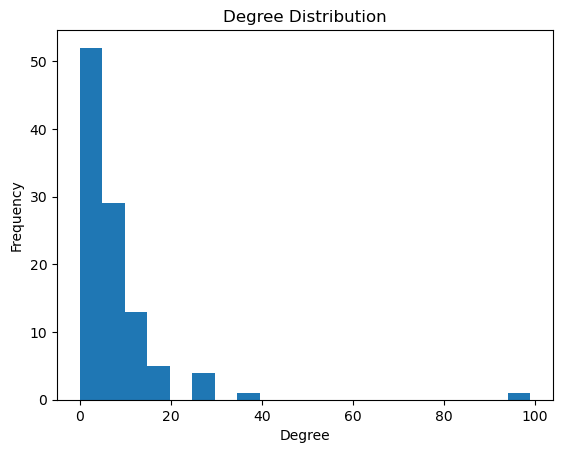

In [12]:
import matplotlib.pyplot as plt

degrees = [val for (node, val) in net.degree()]
plt.hist(degrees, bins=20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()